In [2]:
from scipy.ndimage import imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

[Color Quantization](https://en.wikipedia.org/wiki/Color_quantization) of images is a visual and easily interpretable demonstration of KMeans clustering. In color quantization, the number of distinct colors is reduced in order to show an image on displays with limited color ranges, like an e-ink display, or reduce image size. 

The image used here comes from a [KMeans clustering example](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html) for the openCV library, but the demonstration only showed the original image and then the image transformed by the final results of the clustering. What happened behind the scenes was left out, presumably for conciseness. 

This notebook uses sklearn KMeans to show those hidden steps to and to demo the principles of clustering. The division that occurs for a cluster size of 2 shows that the way a person intuitively groups points may not be the way the code does it.

Load and display image.

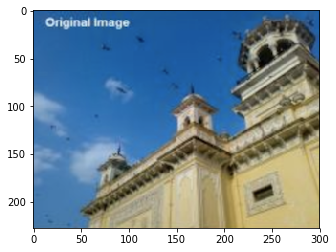

In [3]:
#change to your image location
im = imread('./cloud_small.png')
plt.imshow(im);

First reshape the 228x300x3 array into a form compatible with sklearn. Make three columns that treat the r,g,b color values as x,y,z cartesian coords. 

In [4]:
im_shape = im.shape
print('Original Shape: ',im.shape)
print('Like a list of lists of color coordinate lists')
print(im[0:2,0:3,:],'\n')
im_xyz = im.reshape(-1,3)
print('New Shape: ', im_xyz.shape)
print('Like a list of color coordinate lists')
print(im_xyz[0:4, :])

Original Shape:  (228, 300, 3)
Like a list of lists of color coordinate lists
[[[ 42  97 155]
  [ 42  97 156]
  [ 42  97 156]]

 [[ 41  97 156]
  [ 42  97 156]
  [ 42  97 156]]] 

New Shape:  (68400, 3)
Like a list of color coordinate lists
[[ 42  97 155]
 [ 42  97 156]
 [ 42  97 156]
 [ 42  97 156]]


Change to pandas dataframe for some convenience

In [5]:
colorspace=pd.DataFrame(im_xyz, columns=['x','y','z'])

Plot points using r,g,b color coordinates as x,y,z 

#### How would you group these points and will kmeans with 2 clusters match your grouping? 

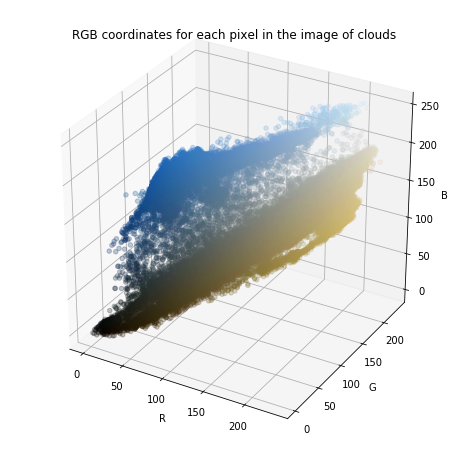

In [5]:
pt_colors = [list(r/255) for r in colorspace.values]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(colorspace.x, colorspace.y, colorspace.z, c=pt_colors, alpha =0.25)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_title('RGB coordinates for each pixel in the image of clouds')
plt.show()

Cluster and plot results for 2,3,4,6,8, and 10 clusters 

Original Image and colorspace


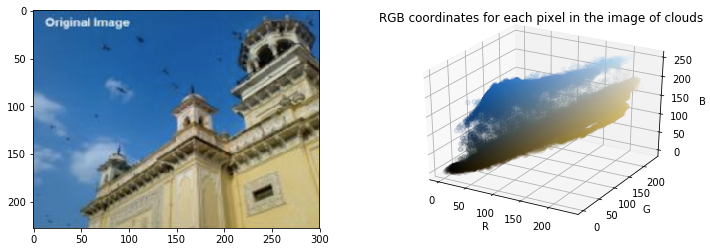


		Image and colorspace for 2 clusters


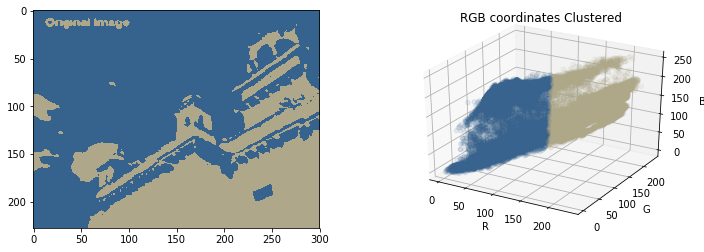


		Image and colorspace for 3 clusters


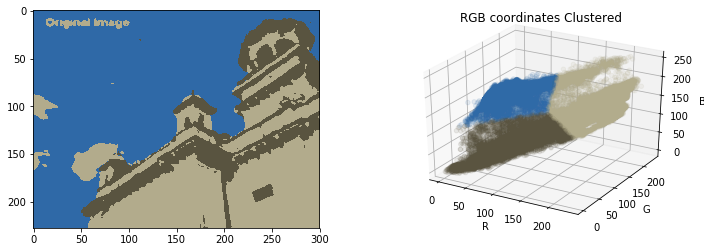


		Image and colorspace for 4 clusters


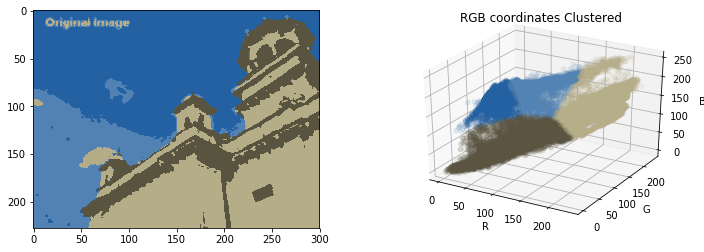


		Image and colorspace for 6 clusters


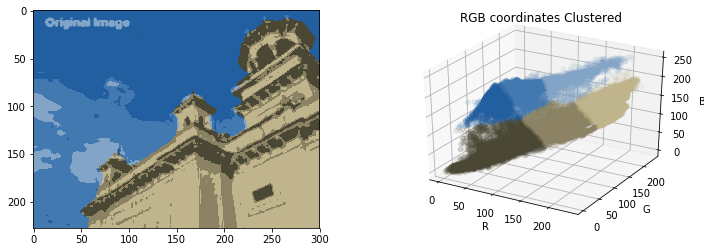


		Image and colorspace for 8 clusters


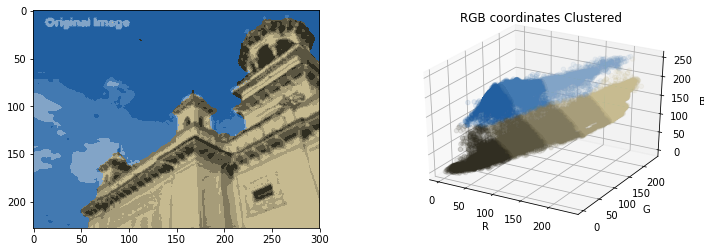


		Image and colorspace for 10 clusters


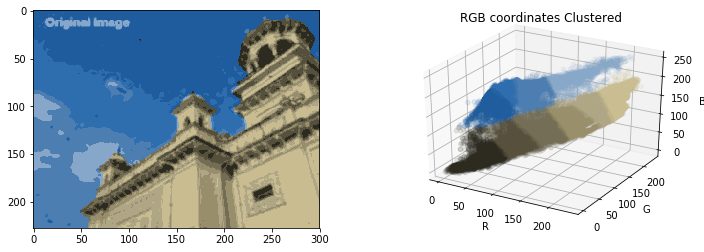

In [6]:
"""Illustrate cluster of for k in KCLUSTERS"""
K_CLUSTERS=[2, 3, 4, 6, 8, 10]

#plot original image
print('Original Image and colorspace')
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.imshow(im)

#plot colorspace for the original image
pt_colors = [list(r/255) for r in colorspace.values]
ax = fig.add_subplot(122, projection='3d')
ax.scatter(colorspace.x, colorspace.y, colorspace.z, c=pt_colors, alpha =0.1)
ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')
ax.set_title('RGB coordinates for each pixel in the image of clouds')
plt.show()

#plot image and color space for different numbers of clusters
SSEs = []
Sil_coefs = []
for n_clust in K_CLUSTERS:
    print('\n\t\tImage and colorspace for {} clusters'.format(n_clust))
    fig = plt.figure(figsize=(12,4))
    estimator = KMeans(n_clusters=n_clust, n_init=10, random_state=10)
    clusters = estimator.fit_predict(colorspace)
    labels = estimator.labels_
    
    #note: the silhoutte_score algorithm is memory intensive.
    #it should be done on a sample of the data
    Sil_coefs.append(silhouette_score(colorspace, labels,
                                      metric='euclidean', sample_size=10**4))
    SSEs.append(estimator.inertia_) 


    #show xyz color space coded by cluster
    colorspace_cl = colorspace.copy()
    colorspace_cl['cl'] = clusters
    cl_means = colorspace_cl.groupby('cl').agg(np.mean)
    cluster_color = [list(cl_means.values[c]/255) for c in clusters]
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(colorspace.x, colorspace.y, colorspace.z, c=cluster_color, alpha =0.1)
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_title('RGB coordinates Clustered')


    #recolor and show image
    newcolorspace = colorspace.copy()
    for cl_num in np.unique(clusters):
        mask = (clusters==cl_num)
        newcolorspace.iloc[mask,:]= newcolorspace.iloc[mask,:].transform(lambda x: 0*x + x.mean())
    ax2 = fig.add_subplot(121)
    ax2.imshow(newcolorspace.astype(np.uint8).values.reshape(im.shape))
    plt.show();
    
    

For two clusters it's not the blue and beige/yellow intuitive grouping, but the alternative darker and lighter grouping.

Silhouette plot and SSE plot are shown below. The sklearn algorithm for silhouette scores uses >32gb of memory for the full image, despite it being only 68.4k points. Instead it is run on 10,000 point sample.

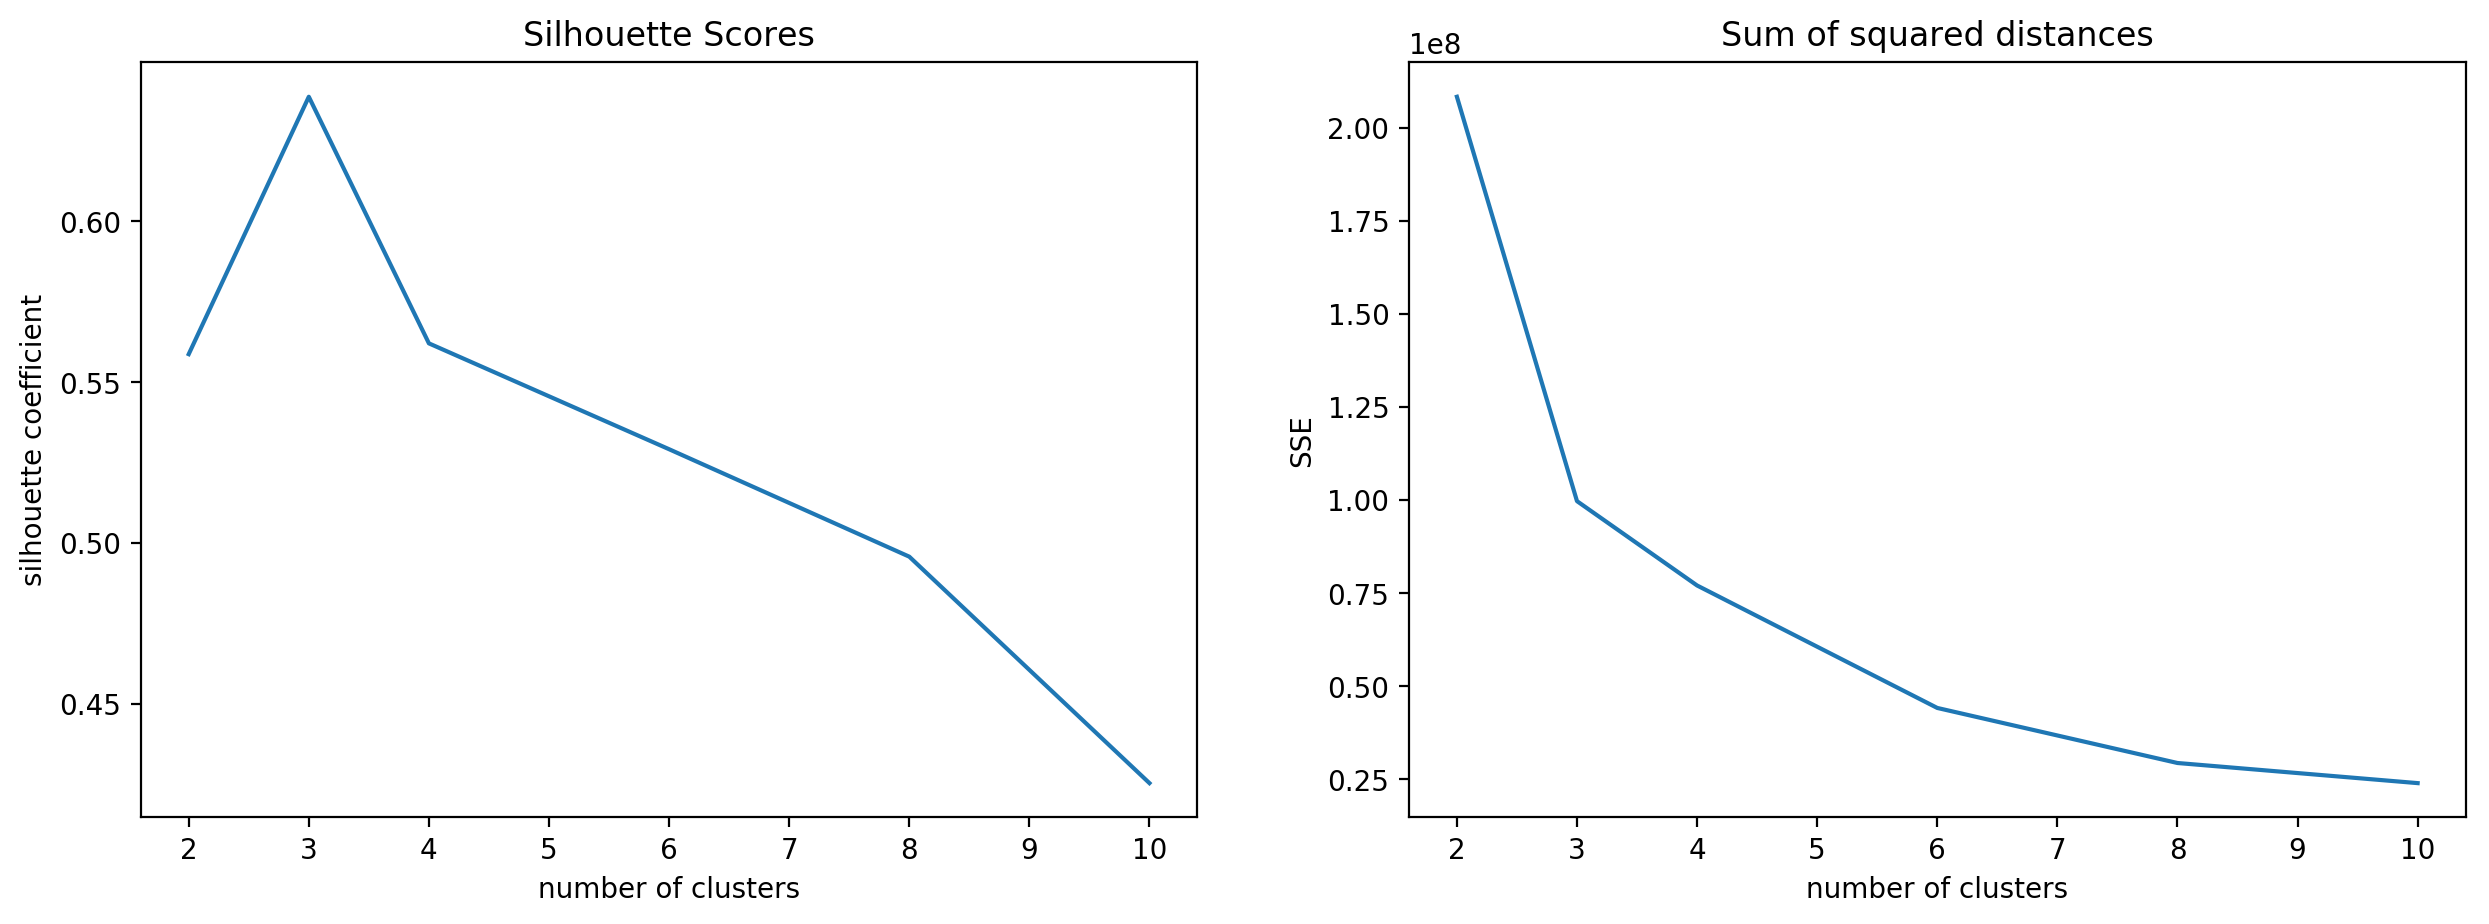

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
ax1.plot(K_CLUSTERS, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')
ax1.set_title('Silhouette Scores');

# plot here on ax2
ax2.plot(K_CLUSTERS, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE')
ax2.set_title('Sum of squared distances');

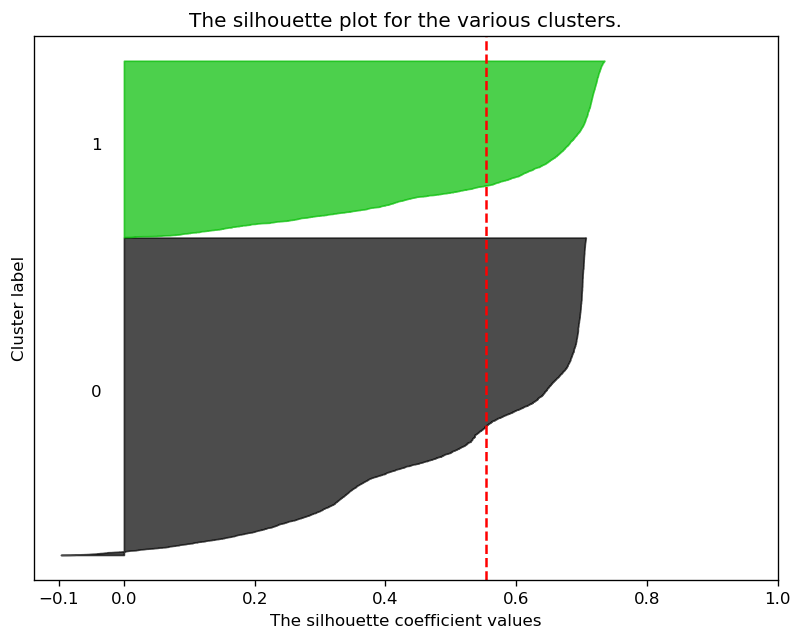

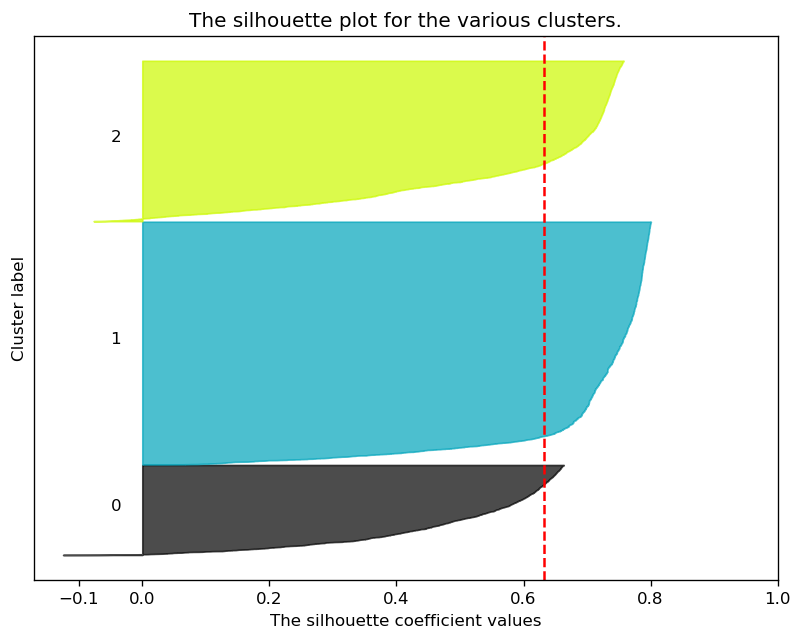

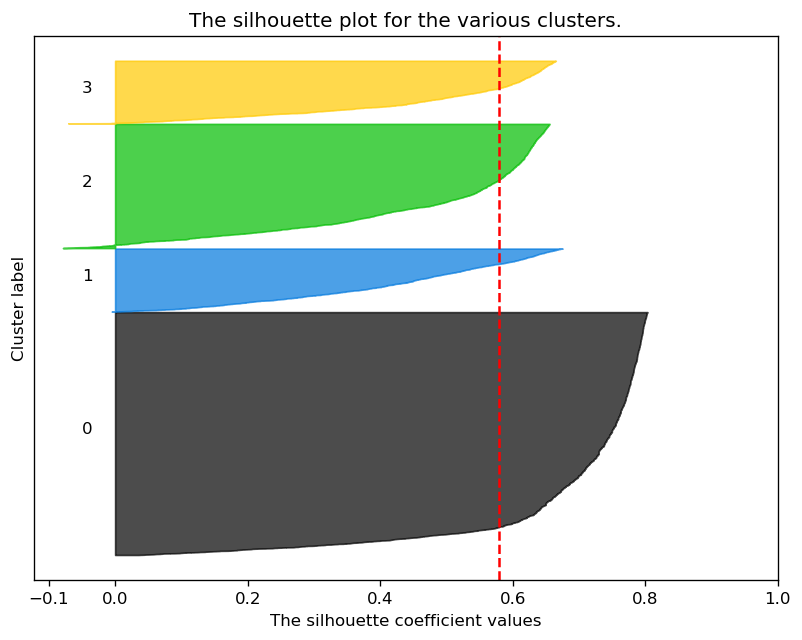

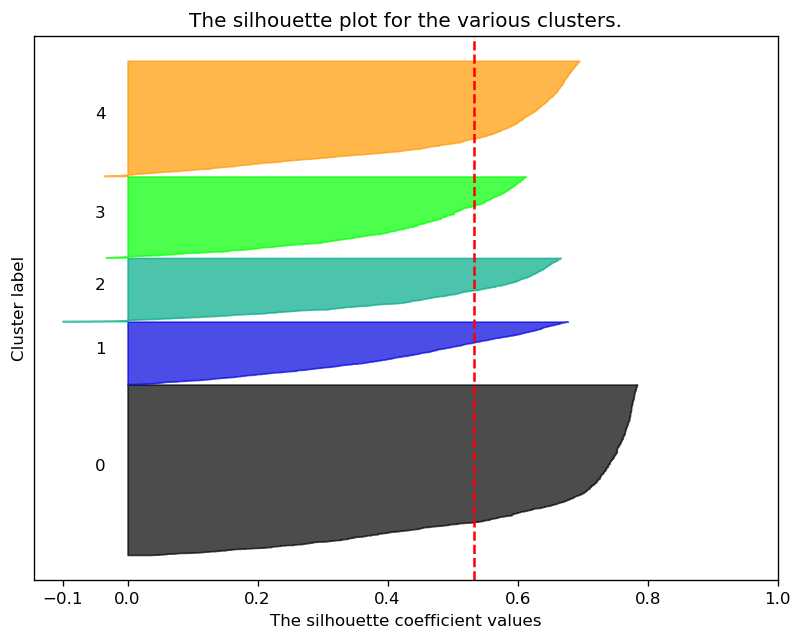

In [17]:
#plot image and color space for different numbers of clusters
SSEs = []
Sil_coefs = []
colorspace_sample=colorspace.sample(10000).copy()
for n_clust in range(2,6):
    plt.figure(dpi=120, figsize=(8,6))
    ax1 = plt.gca()
    estimator = KMeans(n_clusters=n_clust, n_init=10, random_state=10)
    clusters = estimator.fit_predict(colorspace_sample)
    labels = estimator.labels_
    
    #### Remaining code in this cell adapted from an in class example at the Metis Datascience bootcamp 
    #https://www.thisismetis.com
    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(colorspace_sample, labels)
    sample_silhouette_values = silhouette_samples(colorspace_sample, labels)
    y_lower = 100
    for i in range(n_clust):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
